In [76]:
import pandas as pd
import math
import numpy as np
from scipy import stats

# ファイルを読み込む
pd_reader = pd.read_csv("data_10.csv", encoding="ANSI")
df = pd_reader
#df = df.dropna()
factors = ['PER','PBR',
           '配当利回り','reversal','売買回転率',
           'ボラティリティ','自己資本比率','ROE',
           '売上高成長率','売上高営業利益率','accrual比率']

    
display(df)

,yyyymm,code,企業名,業種コード,時価総額,時価総額比率,翌1M収益率,PER,PBR,配当利回り,reversal,売買回転率,ボラティリティ,自己資本比率,ROE,売上高成長率,売上高営業利益率,accrual比率
0,200501,1301,極洋,50,2.316796e+10,0.000063,6.132075,189.794091,16.584526,0.001887,-1.431930,9.964968,9.798452,9.671801,22.033898,-6.904708,2.074782,-1.839077
1,200501,1331,マルハニチロ食品,50,2.944415e+10,0.000081,-1.675978,NaN,NaN,NaN,-1.812655,8.080613,8.959971,NaN,NaN,NaN,NaN,NaN
2,200501,1332,日本水産,50,9.563755e+10,0.000262,1.159420,32.363977,1.172632,0.014493,-2.771182,5.234294,6.459922,7.273836,13.135825,-1.033593,2.058652,-5.059100
3,200501,1334,マルハニチロホールディングス,50,6.030000e+10,0.000165,3.482587,NaN,NaN,NaN,0.166679,9.959333,NaN,NaN,NaN,NaN,NaN,NaN
4,200501,1352,ホウスイ,6050,8.062110e+09,0.000022,35.820896,-305.471125,22.283814,NaN,-3.994950,64.993767,10.731419,31.927423,-13.160518,-18.550438,-1.179532,2.657966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352774,202012,9991,ジェコス,6050,3.497868e+10,0.000051,-1.875000,7.930607,0.626317,0.036458,0.793522,1.528977,8.024715,55.914685,7.969035,32.833341,5.524504,-6.987187
352775,202012,9993,ヤマザワ,6100,1.914856e+10,0.000028,0.000000,-86.271605,0.676529,0.015455,-0.322500,0.719836,3.389391,55.916395,-0.782445,-3.988063,0.571512,-7.163312
352776,202012,9994,やまや,6100,2.360497e+10,0.000034,-0.459559,114.646997,0.738982,0.021140,0.307323,1.313622,9.612572,50.333228,0.643218,-0.710275,2.475501,-0.745420
352777,202012,9995,グローセル,6050,1.189206e+10,0.000017,9.555556,164.233577,0.481392,0.026667,-0.156039,1.864017,6.532688,70.537413,0.287420,-12.388195,-0.088838,-5.330464


In [77]:
# 時間推移関数
def nextym(yyyymm):
    yyyymm = yyyymm + 1
    if yyyymm % 100 == 13:
        yyyymm = yyyymm + 88
    return yyyymm

In [79]:
#因子効果の計測
def calculate_metrics(df, column_name):
    yyyymm = 200501  # 起始日期
    end_date = 202012  # 终止日期

    SPD = []  # 存储 SPD 指标
    TOP = []  # 存储 top_rtn0 指标
    BOT = []  # 存储 bot_rtn0 指标
    top_rtn = []  # 存储 top_rtn 累积值
    bot_rtn = []  # 存储 bot_rtn 累积值

    top_sum = 0.0  # top_rtn 累积值的初始值
    bot_sum = 0.0  # bot_rtn 累积值的初始值
    n = 0
    
    while yyyymm <= end_date:
        
        tmp = df[df['yyyymm'] == yyyymm]
        tmp = tmp.copy()
        for factor in factors:
            tmp[factor].fillna(tmp[factor].mean(), inplace=True)
        
        # 计算 top_rtn0
        top = tmp.loc[:, column_name].quantile(q=0.9)
        tmp_2 = tmp[tmp[column_name] >= top]
        top_rtn0 = tmp_2.loc[:, '翌1M収益率'].mean()

        # 计算 bot_rtn0
        bot = tmp.loc[:, column_name].quantile(q=0.1)
        tmp_2 = tmp[tmp[column_name] <= bot]
        bot_rtn0 = tmp_2.loc[:, '翌1M収益率'].mean()

        # 计算 SPD
        spd0 = bot_rtn0 - top_rtn0
        SPD.append(spd0)

        # 存储 top_rtn0
        TOP.append(top_rtn0)
        top_sum += top_rtn0
        top_rtn.append(top_sum)

        # 存储 bot_rtn0
        BOT.append(bot_rtn0)
        bot_sum += bot_rtn0
        bot_rtn.append(bot_sum)
        
        spd_rtn = np.array(bot_rtn) - np.array(top_rtn)
    
        n = n + 1
        
       
        yyyymm = nextym(yyyymm)  # 更新日期
        
    t = student(pd.Series(SPD).mean(), pd.Series(TOP).var(), pd.Series(BOT).var(), 192, 192)  
    
    return top_rtn,bot_rtn,t,pd.Series(SPD).mean(),pd.Series(SPD).std()


PER 平均: 0.6270991361250481 標準偏差: 1.9590480135099526 t値: 1.0752963200786134
PBR 平均: 0.9303145097317455 標準偏差: 2.299554097325272 t値: 1.5865525506131337
配当利回り 平均: -0.14255951841267386 標準偏差: 2.5364267984362865 t値: -0.226070059739187
reversal 平均: -0.19720962867227596 標準偏差: 4.99958691813088 t値: -0.29090007884479696
売買回転率 平均: 0.01937134223524341 標準偏差: 4.9533063058689795 t値: 0.03143827473807879
ボラティリティ 平均: -0.19320306593559078 標準偏差: 5.477223897740462 t値: -0.3310015627345282
自己資本比率 平均: -0.17340382840205085 標準偏差: 2.692137835892306 t値: -0.3282430846172292
ROE 平均: 0.11360028258180088 標準偏差: 2.550076203160712 t値: 0.18685794347030046
売上高成長率 平均: -0.02462177852596285 標準偏差: 2.336182453289674 t値: -0.04025059103242095
売上高営業利益率 平均: 0.14915374432773584 標準偏差: 2.664889738561395 t値: 0.2603706044103028
accrual比率 平均: 0.32189870663568504 標準偏差: 1.5704003495230996 t値: 0.5665819515273055


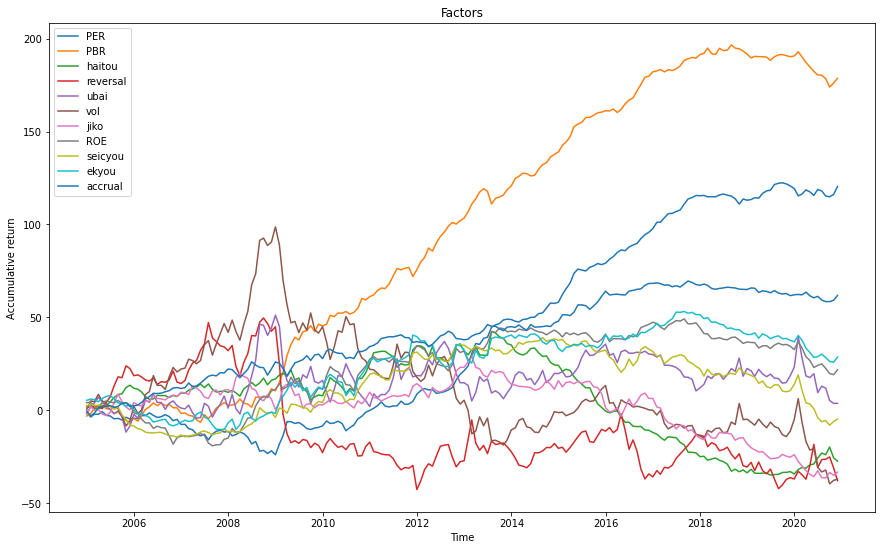

In [80]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']=(14.8, 9.0)

x=pd.date_range('2004-12-01','2020-12-01',freq='M')

factors = ['PER','PBR',
           '配当利回り','reversal','売買回転率',
           'ボラティリティ','自己資本比率','ROE',
           '売上高成長率','売上高営業利益率','accrual比率']

for factor in factors:
    cap_top_acc, cap_bot_acc, cap_t, cap_mean, cap_std = calculate_metrics(df, factor)
    print(factor,'平均:', cap_mean, '標準偏差:', cap_std, 't値:', cap_t)
    
    #図の出力
    plt.plot(x, np.array(cap_bot_acc) - np.array(cap_top_acc))
    plt.legend(["PER","PBR","haitou","reversal","ubai","vol","jiko","ROE","seicyou","ekyou","accrual"],shadow=False,fancybox="blue")
    
plt.xlabel("Time")
plt.ylabel("Accumulative return")
plt.title("Factors")

plt.show()